**GOGOX Data Assignment**


**Part 1: Exploratory analysis of supply and demand**  
The task is to perform an exploratory analysis of data on orders and completed orders, examining supply and demand in order to make recommendations on how to alleviate any imbalances between supply and demand.

In [1]:
#%% import packages
import numpy as np
import pandas as pd
import os
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from scipy import stats

#%% define path
data_path = './data/'

#%% import data
df_order = pd.read_csv(data_path + 'df_order.csv')
df_region = pd.read_csv(data_path + 'df_region.csv')
df_completed = pd.read_csv(data_path + 'df_completed.csv')

#%% join tables and preprocess
# add indicator for weekday, where 1 = Sunday and 7 = Saturday
df_order['created_weekday'] = [a%7 for a in df_order['created_day_id']]
df_order.loc[df_order['created_weekday'] == 0,'created_weekday'] = 7

# convert time to timedelta
df_order['created_time'] = pd.to_timedelta(df_order['created_time'])
df_completed['completed_time'] = pd.to_timedelta(df_completed['completed_time'])

# convert created time into hour blocks for analysis later
df_order['created_hour'] = [a.seconds // 3600 for a in df_order['created_time']]

# for ease of operations, convert days and times to a datetime starting from an arbitrary date: 1 Aug 2021 (sunday)
df_order['created_datetime'] = [dt.datetime(year=2021,month=8,day=1) + dt.timedelta(days=a-1) + b \
                                for a,b in zip(df_order['created_day_id'],df_order['created_time'])]
df_completed['completed_datetime'] = [dt.datetime(year=2021,month=8,day=1) + dt.timedelta(days=a-1) + b \
                                for a,b in zip(df_completed['completed_day_id'],df_completed['completed_time'])]

# join orders and completed, leave out regional characteristics for now
df_combined = pd.merge(df_order, df_completed, on = 'order_request_id', how = 'outer')
#df_combined = pd.merge(df_combined, df_region, left_on = 'pickup_location_region', right_on = 'region')
#df_combined = df_combined.drop(columns = 'pickup_location_region')

# add indicator for whether the order was completed
df_combined.loc[~pd.isnull(df_combined['completed_day_id']),'completed_ind'] = 1
df_combined.loc[pd.isnull(df_combined['completed_day_id']),'completed_ind'] = 0

# calculate time to complete order
df_combined['completion_time'] = df_combined['completed_datetime'] - df_combined['created_datetime']

In [9]:
#%% sanity checks
# check unique
print('Order ID in orders is unique: ' + str(len(df_order['order_request_id']) == len(np.unique(df_order['order_request_id']))))
print('Order ID in completed is unique: ' + str(len(df_completed['order_request_id']) == len(np.unique(df_completed['order_request_id']))))
print('Orders completed in negative days, or over 5 days')
df_combined.loc[[a.days < 0 or a.days > 5 for a in df_combined['completion_time']],['order_request_id','created_day_id','created_time','completed_day_id','completed_time','completion_time']]


Order ID in orders is unique: True
Order ID in completed is unique: True
Orders completed in negative days, or over 5 days


,order_request_id,created_day_id,created_time,completed_day_id,completed_time,completion_time
4160,4160,5,0 days 10:17:58.599000,13.0,0 days 19:54:52.405000,8 days 09:36:53.806000
13458,13458,12,0 days 21:21:55.761000,20.0,0 days 15:21:45.770000,7 days 17:59:50.009000
20837,20837,18,0 days 15:57:27.510000,25.0,0 days 09:29:40.051000,6 days 17:32:12.541000
21093,21093,18,0 days 18:11:43.455000,24.0,0 days 19:22:16.096000,6 days 01:10:32.641000
24093,24093,20,0 days 17:49:03.895000,27.0,0 days 23:46:16.956000,7 days 05:57:13.061000
29128,29128,25,0 days 09:23:57.592000,2.0,0 days 09:34:37.648000,-23 days +00:10:40.056000
30274,30274,25,0 days 19:03:37.999000,1.0,0 days 19:59:33.327000,-24 days +00:55:55.328000
30320,30320,25,0 days 19:58:30.093000,2.0,0 days 15:26:05.450000,-24 days +19:27:35.357000
32101,32101,27,0 days 09:24:31.462000,2.0,0 days 16:50:05.579000,-25 days +07:25:34.117000
32928,32928,27,0 days 15:17:49.868000,2.0,0 days 14:33:56.250000,-26 days +23:16:06.382000


There are orders that took negative time to complete, I assume these are errors in the data.  
There are also orders that took over 1 day. This suggests that the order date might not be the same as the pickup date (i.e. scheduled pickups).  
However I will ignore this for now and assume for simplicity that the created date is the same as the pickup date, as we don't have information on the pickup date.

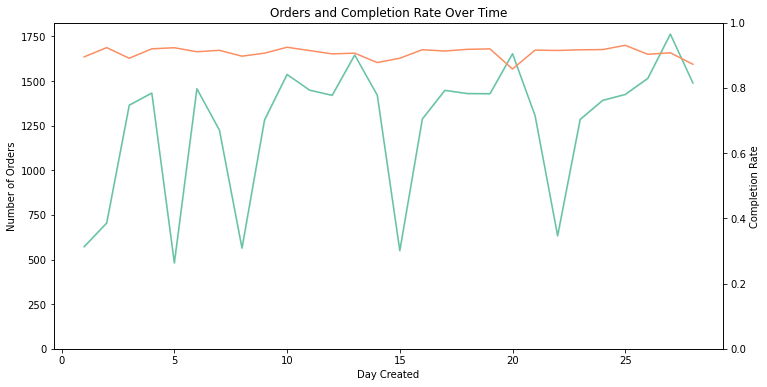

In [14]:
#%% exploratory plot 1: orders and completion rate over time across all regions
palette = ['#66c2a5','#fc8d62','#8da0cb','#e78ac3','#a6d854']
plt.figure(figsize=(12,6))
ax = sns.lineplot(data=df_combined, x='created_day_id', y='created_day_id', color=palette[0], estimator=len)
ax.set(ylim=(0, None))
ax2 = plt.twinx()
ax2 = sns.lineplot(data=df_combined, x='created_day_id', y='completed_ind', color=palette[1], ci=None)
ax2.set(ylim=(0, 1))
ax.set(title='Orders and Completion Rate Over Time', xlabel='Day Created', ylabel='Number of Orders');
ax2.set(ylabel='Completion Rate');

We don't have a direct measure of supply, so we'll use order completion rate as a proxy measure.  
  
**Observations:** (will be tested later) 
* There is a huge amount of variation between days.
* Days 1, 8, 15, 22 all have much fewer orders. These are all Sundays, suggesting that demand is lower on Sundays. Although it seems strange that the same is not true for Saturdays.
* Days 2 (Monday) and 5 (Thursday) also have fewer orders. It is unclear why this is the case, potentially holidays could be factor that we do not have visibility on.
* There does not seem to be a strong correlation between number of orders and completion rate, at least by visual inspection. Completion rate does vary day to day, but the variation is much smaller.

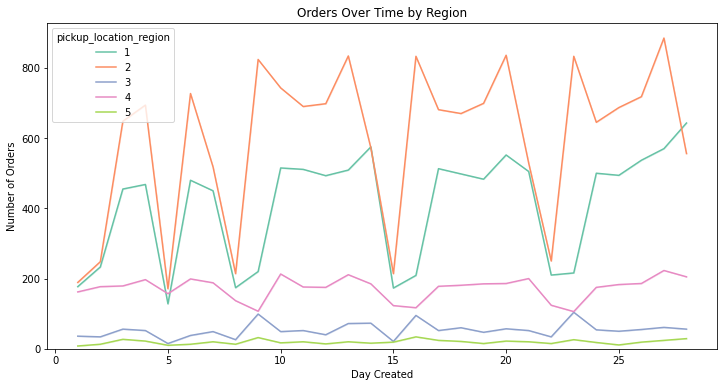

In [17]:
#%% exploratory plot 2: orders over time for each region
plt.figure(figsize=(12,6))
ax = sns.lineplot(data=df_combined, x='created_day_id', y='created_day_id', hue='pickup_location_region', palette=palette, estimator=len)
ax.set(ylim=(0, None))
ax.set(title='Orders Over Time by Region', xlabel='Day Created', ylabel='Number of Orders');

**Observations:**
* Regions vary widely in average number of orders.
* There is still large day-to-day variation. The regions covary somewhat, but they do seem to have different weekday patterns.
* It would be worth exploring the weekday effects for each region.

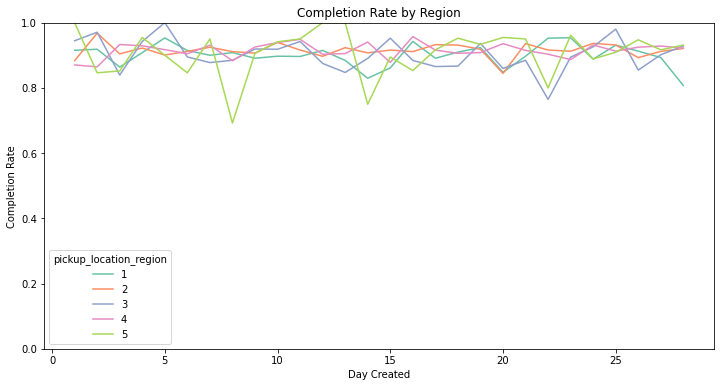

In [19]:
#%% exploratory plot 3: completion rate over time for each region
plt.figure(figsize=(12,6))
ax = sns.lineplot(data=df_combined, x='created_day_id', y='completed_ind', hue='pickup_location_region', palette=palette, ci=None)
ax.set(ylim=(0, 1))
ax.set(title='Completion Rate by Region', xlabel='Day Created', ylabel='Completion Rate');

**Observations:**
* Regions do not vary widely in completion rate. Average completion rates are relatively similar.
* Regions do not seem to covary strongly in completion rate.

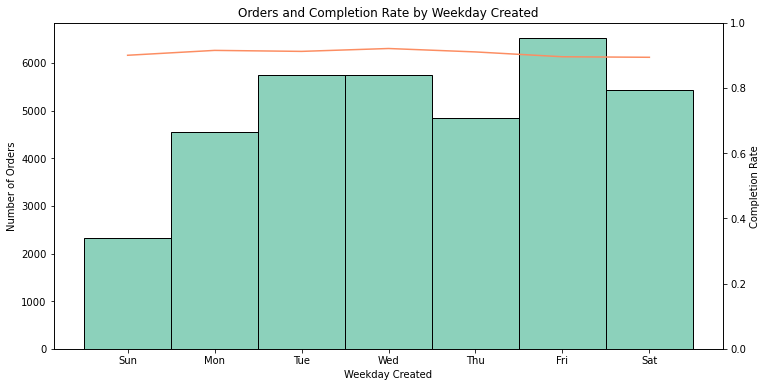

In [24]:
#%% exploratory plot 4: distribution over weekday
plt.figure(figsize=(12,6))
ax = sns.histplot(df_combined['created_weekday'], color=palette[0],discrete=True)
ax.set(xticks=[1,2,3,4,5,6,7], xticklabels=['Sun','Mon','Tue','Wed','Thu','Fri','Sat']);
ax2 = plt.twinx();
ax2 = sns.lineplot(data=df_combined, x='created_weekday', y='completed_ind', color=palette[1], ci=None)
ax2.set(ylim=(0, 1));
ax.set(title='Orders and Completion Rate by Weekday Created', xlabel='Weekday Created', ylabel='Number of Orders');
ax2.set(ylabel='Completion Rate');

**Observations:**
* I would expect weekend effects, i.e. supply or demand being different on weekends vs. weekdays
* Sunday (weekday=1) has fewer orders than other weekdays
* Completion rate does not seem to vary by weekday

Text(0.5, 0.98, 'Number of Orders by Weekday by Region')

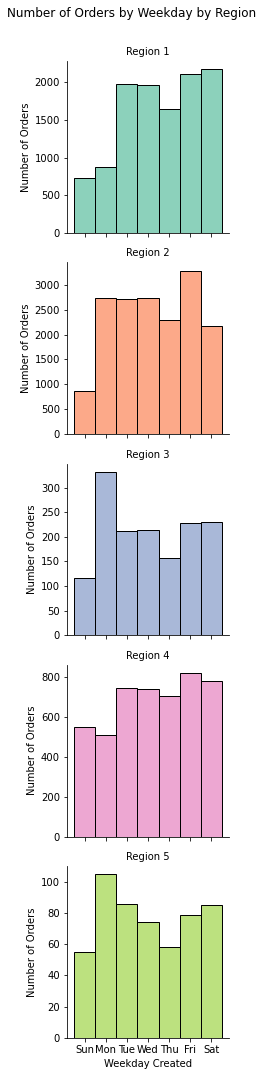

In [31]:
#%% exploratory plot 5: distribution of orders over weekday by region
ax = sns.FacetGrid(df_combined, row='pickup_location_region', hue='pickup_location_region', palette=palette, sharey=False)
ax.map_dataframe(sns.histplot, x='created_weekday', stat='count', discrete=True)
ax.set_axis_labels('Weekday Created', 'Number of Orders')
ax.set_titles(row_template="Region {row_name}")
ax.set(xticks=[1,2,3,4,5,6,7], xticklabels=['Sun','Mon','Tue','Wed','Thu','Fri','Sat']);
ax.fig.subplots_adjust(top=0.93)
ax.fig.suptitle('Number of Orders by Weekday by Region')

**Observations:**
* While Sunday having fewer orders is a common pattern, each region seems to have its own weekday effects.
* Region 1 in particular has much fewer orders on Monday.
* Interestingly, Saturday does not seem to exhibit the same effect as Sunday, which is what I would have intuitively expected.
* From this, it seems that trying to boost demand on Sundays might be a good avenue to explore.

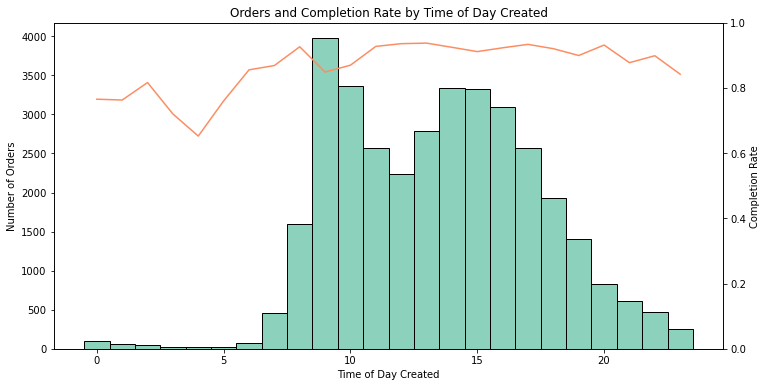

In [33]:
#%% exploratory plot 6: distribution over time of day
plt.figure(figsize=(12,6))
ax = sns.histplot(df_combined['created_hour'], color=palette[0], discrete=True)
ax2 = plt.twinx()
ax2 = sns.lineplot(data=df_combined, x='created_hour', y='completed_ind', color=palette[1], ci=None)
ax2.set(ylim=(0, 1));
ax.set(title='Orders and Completion Rate by Time of Day Created', xlabel='Time of Day Created', ylabel='Number of Orders');
ax2.set(ylabel='Completion Rate');

**Observations:**
* There is a relationship between time of day and completion rate, but it is clearly not linear.
* There are very few orders between midnight and 7AM
* Demand has peaks around 9-11AM and 2-5PM.
* Completion rate seems to be positively correlated with orders - i.e. the times with more orders also have more drivers
* There is a dip in completion rate at the 9-10AM peak hours - suggesting demand outpaces supply in these hours

Text(0.5, 0.98, 'Number of Orders by Time of Day by Region')

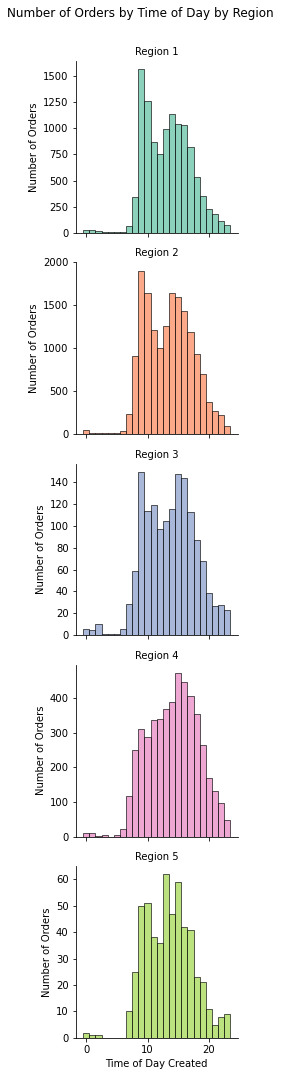

In [34]:
#%% exploratory plot 7: distribution over time of day by region
ax = sns.FacetGrid(df_combined, row='pickup_location_region', hue='pickup_location_region', palette=palette, sharey=False)
ax.map_dataframe(sns.histplot, x='created_hour', stat='count', discrete=True)
ax.set_axis_labels('Time of Day Created', 'Number of Orders');
ax.set_titles(row_template="Region {row_name}");
ax.fig.subplots_adjust(top=0.93)
ax.fig.suptitle('Number of Orders by Time of Day by Region')

**Observations:**
* The patterns in time of day are similar across regions.
* All regions have a morning peak in demand at around 9-11AM, and a secondary afternoon peak around 2-5PM, except for region 4 which does not have a morning peak.

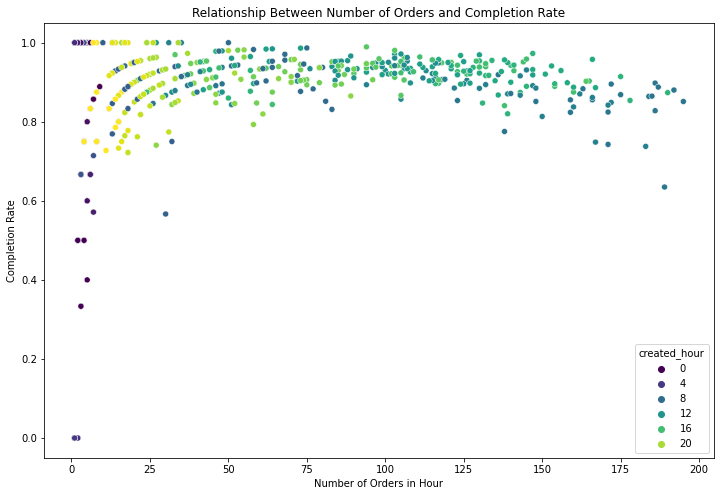

In [37]:
#%% exploratory plot 8: relationship between number of orders in hour and completion rate
df_combined_gp = df_combined.groupby(['created_day_id','created_hour'])['completed_ind'].agg(['mean','count'])
plt.figure(figsize=(12,8))
ax = sns.scatterplot(data=df_combined_gp, x='count', y='mean', hue='created_hour', palette='viridis')
ax.set(title='Relationship Between Number of Orders and Completion Rate', xlabel='Number of Orders in Hour', ylabel='Completion Rate');

I want to see if there is a relationship between excess demand and low completion rate
i.e. in times where there is a lot of demand, does supply fail to keep up?
There does seem to be a drop in completion rate when demand is high, but also when demand is low.
However, from the previous plot, we know that demand and supply vary hugely based on time of day.
I want to further see if there is an effect of extremely high/low demand on completion rate, independent of time of day.
To visualise this, I'll mimic an hour fixed effect by taking the difference from the mean for that hour of day.

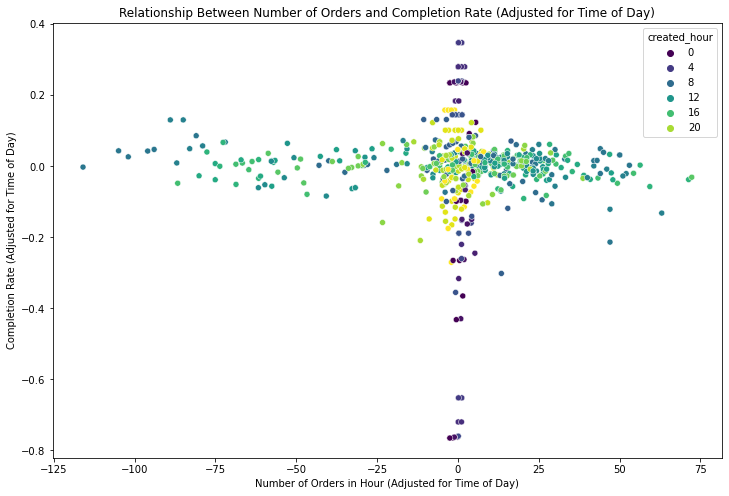

In [38]:
#%% exploratory plot 9: relationship between number of orders in hour and completion rate (adjusted for time of day)
df_combined_gp = df_combined.groupby(['created_day_id','created_hour'])['completed_ind'].agg(['mean','count'])
df_combined_hr = df_combined.groupby(['created_hour'])['completed_ind'].agg(['mean','count'])
df_combined_hr = df_combined.groupby(['created_hour'])['completed_ind'].agg(['mean','count'])
df_combined_hr['count'] = df_combined_hr['count'] / len(df_combined['created_day_id'].unique())
df_combined_hr = df_combined_hr.rename(columns={'mean':'hr_mean','count':'hr_count'})
df_combined_gp = pd.merge(df_combined_gp, df_combined_hr, on = 'created_hour', how = 'left')
df_combined_gp['mean_diff'] = df_combined_gp['mean'] - df_combined_gp['hr_mean']
df_combined_gp['count_diff'] = df_combined_gp['count'] - df_combined_gp['hr_count']
plt.figure(figsize=(12,8))
ax = sns.scatterplot(data=df_combined_gp, x='count_diff', y='mean_diff', hue='created_hour', palette='viridis')
ax.set(title='Relationship Between Number of Orders and Completion Rate (Adjusted for Time of Day)', \
       xlabel='Number of Orders in Hour (Adjusted for Time of Day)', ylabel='Completion Rate (Adjusted for Time of Day)');

After adjusting for time of day, there is basically no relationship between demand and completion rate.
This suggests that the time of day captures all of the effect of undersupply, and there is no additional effect of excess demand.
In real terms, this means that it wouldn't be necessary to implement variable incentives, such as surge pricing, which was one idea for correcting excess demand.
Instead of variable surge pricing based on how many orders are being placed, we could just implement incentives for driving at certain times of day.

**Supply side testing**  
To test whether a range of variables affects the supply, I'll run a logistic regression.  
This will tell us whether a factor is statistically significant in predicting the probability of an order being completed, which is a measure of supply/demand imbalance and an indirect measure of supply.  
  
I'd like to note that I am specifically not using the regional characteristics. There are a few reasons for this.  
1. These characteristics are not actionable. It is unlikely that the company could actively impact road length, size, bus stations or restaurants through any concerted effort.
Thus even if we knew what characteristics were associated with supply/demand, it would not help us solve the immediate problem.
These characteristics may be useful in determining future strategy, for example what type of region might be best to expand into, but I will leave this as a problem for later.
2. With only 5 regions and no further information about our business in those regions, I would not consider any inferences about the effect of those regional characteristics valid.
For example, the population size and density could vary widely between regions, or perhaps there have been concentrated marketing campaigns in one region but not another.
With so little information and only a small number of regions to draw inferences from, I do not think it would be reasonable to draw any conclusions about the regional characteristics.


In [42]:
# set up training data
y = df_combined[['completed_ind']]
X = df_combined[['created_weekday','created_day_id','created_hour','pickup_location_region']]
# create dummy columns for categorical variables weekday and region
X = pd.get_dummies(X, columns = ['created_weekday','created_hour','pickup_location_region'], prefix = ['created_weekday','created_hour','region'])
# for dummy variables, drop the baseline classes.
# use region 1, Monday, and 12PM noon as the baseline classes
X = X.drop(columns=['region_1','created_weekday_2','created_hour_12'])
X = sm.add_constant(X)

# fit logit model
log_reg = sm.Logit(y, X.astype(float)).fit_regularized()
log_reg.summary()

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.3030226157270372
            Iterations: 260
            Function evaluations: 265
            Gradient evaluations: 260


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:          completed_ind   No. Observations:                35163
Model:                          Logit   Df Residuals:                    35128
Method:                           MLE   Df Model:                           34
Date:                Sun, 22 Aug 2021   Pseudo R-squ.:                 0.02188
Time:                        03:34:50   Log-Likelihood:                -10655.
converged:                       True   LL-Null:                       -10894.
Covariance Type:            nonrobust   LLR p-value:                 1.623e-79
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 2.6209      0.110     23.913      0.000       2.406       2.836
created_day_id       -0.0005      0.002     -0.187      0.852      -0.005       0.004
created_weekday_1    -0.1581      0.089     -1.779      0.075      -0.332       0.016
created_weekday_3     0.0103      0.072      0.144      0.885      -0.130       0.151
created_weekday_4     0.1107      0.073      1.514      0.130      -0.033       0.254
created_weekday_5    -0.0189      0.075     -0.253      0.800      -0.165       0.127
created_weekday_6    -0.2017      0.068     -2.963      0.003      -0.335      -0.068
created_weekday_7    -0.1811      0.071     -2.553      0.011      -0.320      -0.042
created_hour_0       -1.4731      0.254     -5.794      0.000      -1.971      -0.975
created_hour_1       -1.4933      0.318     -4.690      0.000      -2.117      -0.869
created_hour_2       -1.1139      0.381     -2.922      0.003      -1.861      -0.367
created_hour_3       -1.7192      0.454     -3.790      0.000      -2.608      -0.830
created_hour_4       -2.0456      0.446     -4.583      0.000      -2.920      -1.171
created_hour_5       -1.4566      0.480     -3.034      0.002      -2.398      -0.515
created_hour_6       -0.9549      0.338     -2.827      0.005      -1.617      -0.293
created_hour_7       -0.8254      0.163     -5.075      0.000      -1.144      -0.507
created_hour_8       -0.1851      0.129     -1.436      0.151      -0.438       0.068
created_hour_9       -0.9506      0.097     -9.793      0.000      -1.141      -0.760
created_hour_10      -0.7770      0.100     -7.736      0.000      -0.974      -0.580
created_hour_11      -0.1337      0.115     -1.164      0.245      -0.359       0.092
created_hour_13       0.0290      0.116      0.250      0.803      -0.199       0.257
created_hour_14      -0.1804      0.108     -1.665      0.096      -0.393       0.032
created_hour_15      -0.3565      0.106     -3.373      0.001      -0.564      -0.149
created_hour_16      -0.2005      0.109     -1.832      0.067      -0.415       0.014
created_hour_17      -0.0402      0.117     -0.343      0.732      -0.270       0.189
created_hour_18      -0.2512      0.120     -2.086      0.037      -0.487      -0.015
created_hour_19      -0.5062      0.124     -4.092      0.000      -0.749      -0.264
created_hour_20      -0.0775      0.162     -0.478      0.633      -0.395       0.240
created_hour_21      -0.7176      0.151     -4.762      0.000      -1.013      -0.422
created_hour_22      -0.5110      0.175     -2.917      0.004      -0.854      -0.168
created_hour_23      -0.9772      0.193     -5.060      0.000      -1.356      -0.599
region_2              0.2204      0.042      5.289      0.000       0.139       0.302
region_3              0.0248      0.092      0.270      0.787      -0.155       0.205
region_4              0.2065      0.061      3.374      0.001       0.087       0.326
region_5              0.1432      0.154      0.930      0.3

**Interpretation:**
* Using a 5% significance level as a cutoff, created_day_id is not significant, so there is not a linear time trend observed (at least not in this short a period)
* weekday is correlated with completion rate. Using Monday as a baseline, Friday and Saturday are significantly different, all with lower completion rates than the weekdays. However the effect size is small.
* The time of day is correlated with completion rate. I wouldn't be comfortable interpreting each of the effect sizes for each hour as statistically valid, as it would be p-hacking with so many variables, but in general it is clear that the late night and early morning hours have a lower completion rate.
* Region 2 and 4 have a higher completion rate relative to the baseline rate of region 1. Although the effect size of this is small.
* Overall, the variables we can see don't explain a very large part of the completion rate. The completion rate doesn't vary much, and most of that variation is noise (or caused by unobservables), with only a small part being explaine by what we can observe in this dataset.
  
My takeaways for this would be:
* Time of day is the biggest factor in supply/demand imbalance, and company policies should aim to target that first and foremost.
* There could be some benefits from trying to target supply on certain days of the week, or certain regions, but the impact would likely be small.
* Given that the supply doesn't vary much and is not well explained by what we can observe in the data, it may be more useful to target demand.


**Demand side testing**  
I'm going to do a simple OLS just to get an idea of how well time of day and weekday explain the variation.
Given that we've seen each region has its own patterns, it would make sense to build a separate model for each region when doing OLS.
I'm just going to do one for region 1 to check the quality of the fit.

In [43]:
# group the data by day and hour
df_combined_gp = df_combined.groupby(['created_day_id','created_hour','pickup_location_region','created_weekday'])['created_hour'].agg(['count'])
df_combined_gp = df_combined_gp.reset_index(level=['created_day_id','created_hour','pickup_location_region','created_weekday'])
# do only region 1 for now
df_combined_gp = df_combined_gp.loc[df_combined_gp['pickup_location_region']==1,]

y = df_combined_gp[['count']]
X = df_combined_gp[['created_day_id','created_hour','created_weekday']]
# create dummy columns for categorical variables weekday and hour
X = pd.get_dummies(X, columns = ['created_weekday','created_hour'], prefix = ['created_weekday','created_hour'])
# for dummy variables, drop the baseline classes.
# use Monday, and 12PM noon as the baseline classes
X = X.drop(columns=['created_weekday_2','created_hour_12'])
X = sm.add_constant(X)

# fit OLS
ols_reg = sm.OLS(y, X.astype(float)).fit()
ols_reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  count   R-squared:                       0.789
Model:                            OLS   Adj. R-squared:                  0.776
Method:                 Least Squares   F-statistic:                     63.60
Date:                Sun, 22 Aug 2021   Prob (F-statistic):          9.75e-152
Time:                        03:37:15   Log-Likelihood:                -1988.4
No. Observations:                 542   AIC:                             4039.
Df Residuals:                     511   BIC:                             4172.
Df Model:                          30                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                14.0099      2.221      6.308      0.000       9.647      18.373
created_day_id        0.2208      0.053      4.133      0.000       0.116       0.326
created_weekday_1    -1.3144      1.596     -0.823      0.411      -4.450       1.821
created_weekday_3    14.5498      1.601      9.090      0.000      11.405      17.694
created_weekday_4    14.0088      1.597      8.770      0.000      10.871      17.147
created_weekday_5     9.6719      1.623      5.961      0.000       6.484      12.860
created_weekday_6    15.4223      1.607      9.594      0.000      12.264      18.580
created_weekday_7    15.4350      1.596      9.669      0.000      12.299      18.571
created_hour_0      -25.8405      3.210     -8.049      0.000     -32.147     -19.534
created_hour_1      -25.3459      3.134     -8.088      0.000     -31.502     -19.189
created_hour_2      -27.9317      3.284     -8.505      0.000     -34.384     -21.480
created_hour_3      -29.6490      3.759     -7.887      0.000     -37.034     -22.264
created_hour_4      -23.6391      3.607     -6.554      0.000     -30.726     -16.553
created_hour_5      -26.3501      4.141     -6.363      0.000     -34.486     -18.214
created_hour_6      -26.1481      4.151     -6.300      0.000     -34.303     -17.994
created_hour_7      -24.2735      2.719     -8.927      0.000     -29.615     -18.932
created_hour_8      -14.4643      2.611     -5.540      0.000     -19.594      -9.335
created_hour_9       28.8929      2.611     11.066      0.000      23.763      34.022
created_hour_10      18.1786      2.611      6.963      0.000      13.049      23.308
created_hour_11       4.0357      2.611      1.546      0.123      -1.094       9.165
created_hour_13       8.4643      2.611      3.242      0.001       3.335      13.594
created_hour_14      13.8571      2.611      5.307      0.000       8.728      18.987
created_hour_15      10.3214      2.611      3.953      0.000       5.192      15.451
created_hour_16       9.8929      2.611      3.789      0.000       4.763      15.022
created_hour_17       2.3929      2.611      0.916      0.360      -2.737       7.522
created_hour_18      -7.8571      2.611     -3.009      0.003     -12.987      -2.728
created_hour_19     -14.1786      2.611     -5.430      0.000     -19.308      -9.049
created_hour_20     -18.5714      2.611     -7.113      0.000     -23.701     -13.442
created_hour_21     -20.4286      2.611     -7.824      0.000     -25.558     -15.299
created_hour_22     -23.0536      2.635     -8.748      0.000     -28.231     -17.876
created_hour_23     -23.3173      2.719     -8.574      0.000     -28.660     -17.975
==============================================================================
Omnibus:                       27.334   Durbin-Watson:                   0.970
P

**Interpretation:**
* Looking at the R squared, the time of day and day of week actually explain the majority of the variation in number of orders.
* Give that a model could be a good predictor, if we had more rich data it might be worth looking into building a more sophisticated model such as using an ensemble method.
* However with just this dataset that would be way overkill.

**My conclusions**  
On the supply side: I would recommend to implement incentives to drive during the morning peak hours of 9-11AM, for example increased peak pricing, or a higher rate for drivers during those hours.
This is the time where the demand is greatest, and also when supply fails to meet the demand, so would be my first target to alleviate supply/demand imbalance.
However, the supply side might not be the largest issue to be addressed, as the variation in demand is much greater.
From our exploration, we saw that the day-to-day variation in orders is massive. Day of the week and time of day are important factors, but there are also other factors not visible to us.

On the demand side: If number of orders is the biggest objective, I might suggest offering incentives during low-demand times, e.g. discounts for orders on Sundays, or off-peak hours.
However profit-wise it's not clear that it would be beneficial to try to shift demand from one time to another, except perhaps trying to alleviate the 9-11AM peak hours.
It may be worth exploring further to see why certain days see so much more/less demand.
Other variables that might be interesting to look at could be weather, events or holidays. This could help us predict demand a bit better.

Another key piece of data missing is price. I imagine that order price would be a key determining factor in supply, i.e. drivers may choose not to take cheap orders.
I had a look at some of the reviews on the app and some of the negative experiences were from customers having drivers cancel once they see that the order value is low.
So that might be an interesting area to explore, e.g. could we alter the pricing scheme to make those orders more desirable.
With price, we could also look at whether we are pricing optimally based on the elasticity.
For example it may be optimal to charge higher prices during peak times, if customers are willing to pay.
We could test this by running an experiment, e.g. randomly allocating a subset of customers to receive higher peak pricing, and testing whether they are willing to pay.

**Other ideas**
* We could train a machine learning model to predict how much demand there will be at a certain location/time given the characteristics, which we could use to forecast times of high/low demand. However asides from adjusting pricing I'm not sure what actions we could take to respond, as we cannot directly set supply.
* One idea I had was providing data assets to drivers that might be useful to them, for example telling them what locations and times might be hotspots for unfulfilled demand, so they might adjust their behaviour to capture more orders.
* I expect drivers to be pretty savvy, so anything that aligns their incentives with those of GOGOX and helps them increase their own revenue is likely going to be beneficial.
* Another thing that could be built from the data is a summary of driver KPIs, such as number of orders taken per day, most active times of day, preferred regions, average completion time etc. Not sure if it would be useful to actively monitor these KPIs, but they could potentially be used as a basis to offer rewards to incentivize drivers, e.g. a cash bonus for completing X orders within a day.
* Other driver characteristic such as experience, customer rating, and measures of driving quality may also be useful to reward positive traits, those might be interesting pieces of additional data to explore.


**Part 2: Cohort calculation in SQL**

Below is a string of SQL code to count the number of drivers in a cohort, with a cohort being defined as a driver join date and order completion date. I assume what we are aiming for is the number of drivers from each join date that completed an order on each date.

>SELECT a.completed_day_id, b.driver_joined_day, COUNT(DISTINCT *) AS count_of_drivers  
FROM table_completed_orders a  
LEFT JOIN  
    (SELECT MIN(completed_day_id) AS driver_joined_day, driver_id  
    FROM table_completed_orders  
    GROUP BY driver_id) b  
ON a.driver_id = b.driver_id  
GROUP BY a.completed_day_id, b.driver_joined_day  
;

**Part 3: Statistical test**

We would like to test whether demand is significantly different between day 14-20 vs. day 21-27.  
We can test this by performing a t-test for equality of means.  
We can aggregate by day and test whether the number of orders per day is statistically different between the two weeks.

In [45]:
wk3 = df_order[(df_order['created_day_id'] >= 14) & (df_order['created_day_id'] <= 20)]
wk4 = df_order[(df_order['created_day_id'] >= 21) & (df_order['created_day_id'] <= 27)]
wk3 = wk3.groupby(['created_day_id'])['created_day_id'].agg(['count'])
wk4 = wk4.groupby(['created_day_id'])['created_day_id'].agg(['count'])
stats.ttest_ind(wk3, wk4, equal_var=True)

Ttest_indResult(statistic=array([-0.07614575]), pvalue=array([0.94055793]))

The p-value is not less than 0.05, thus we would not reject the null hypothesis at 5% significance level.
We would conclude that the demand is not significantly different between week 3 and week 4.

Although one thing to note is that we don't have a fixed unit of observation for demand, we could aggregate at any arbitrary level and get potentially different results.
For example, below we can aggregate by day and hour as the unit of observation.

In [46]:
wk3 = wk3.groupby(['created_day_id','created_hour'])['created_day_id'].agg(['count'])
wk4 = wk4.groupby(['created_day_id','created_hour'])['created_day_id'].agg(['count'])
wk3 = df_order[(df_order['created_day_id'] >= 14) & (df_order['created_day_id'] <= 20)]
wk4 = df_order[(df_order['created_day_id'] >= 21) & (df_order['created_day_id'] <= 27)]
stats.ttest_ind(wk3, wk4, equal_var=True)

KeyError: 'created_hour'

However the p-value is still similar, so I think fair to conclude the number of orders is not significantly different between the two weeks. 